In [14]:
# Import our ARIMA model 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as st
import numpy as np

# Import Numerical Analysis 
import scipy  
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Import Data analytics
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt 
from pandas import * 
from datetime import datetime
import pandas as pd
from pandas.plotting import autocorrelation_plot
import os

import warnings 
warnings.filterwarnings("ignore")
sns.set()

## tsplot 
- Stock["Feature"] to plot 

- No. of times a price appears

- AutoCorrelationFunction

- Partial AutoCorrelation Function   

In [16]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## ARIMA_PLOT_KI ANALYISATION 
*HOW IT WORKS*
Function Definition: 
 Parameters; 
  - series: The time series data as a pandas series
  - order: A tuple of parameters (p, d, q) for ARIMA model where:
      - p: Number of lag observations included in the model
      - d: degree of differencing
      - q: Size of Moving average window
  - train_size_percent: Proportion of the dataset to be used as the 
                        training set.
  - scale: Scaling factor for the data visualization, set to 1 
           (default)

*DATA PREPROCESSING* 

When preprocessing our data we will want to convert the series into a dataframe. It will also name the single column as 'actual'

When it comes to handling duplicates, we will simply remove the index values while keeping the previous occurence. Instead of just removing null values - this can lead to inaccurate data - the code will resample the data to daily frequency, filling missing dates using forward fill which carries the last known value forward. 

*TRAIN/TEST SPLIT* 

"train_size_percent" will calculate the size of training set. It will identify the starting index of the test set. 

*ERROR CALCULATION*

Using Mean Squared Error (MSE) we can calculate the MSE between the actual values and predictions to quantify the forecasting error. 

*DATA SCALING & PLOTTING* 
When scaling data, we want to make sure that it correctly fits the graph. We do this by dividing the actual and predicted values by the scale parameter to fit. 

In [18]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# AIC, BIC, HQIC Purpose

## Definition & Parameters:
The function below takes in a time series and two optional parameters "max_ar" & "max_ma" which set the maximum number of AutoRegressive (AR) and Moving Average (MA) terms, respectively. Both are set to their default value of 4. 

### AIC (Akaike Information Criterion)
Definition: AIC is defined as 

>AIC = 2*k* - 2ln(*L*)

where: <br>
    - ***k*** is the number oif parameters in the model <br>
    - ***L*** is the minimum value of the likelihood function for the model<br>

#### Interpretation
The AIC estimates the relative quality of a statistical model for a given dataset. 
A lower AIC value suggests a better model when balancing the fit and complexity

#### Characteristics
AIC tends to favor models that have a good fit, but it includes a penalty for having too many parameters to avoid overfitting.

### BIC (Bayesian Information Criterion)
Definition: BIC is defined as 

>BIC = *k*ln(*n*) - 2ln(*L*) 

Where: <br>
    - ***k*** is the number of parameters<br>
    - ***n*** is the number of observations (sample size)<br>
    - ***L*** is the maximum likelihood of the model <br>

#### Interpretation
Like AIC, a lower BIC value indicates a preferable model. 
However, BIC imposes a harsher penalty on models with more parameters, espicially as the sample size ***n*** increases

#### Characteristics
BIC tends to favor more simpler models compared to AIC, making it particularly useful when the risk of overfitting is high. 

### HQIC (Hannan-Quinn Information Criterion)
Definition: HQIC is defined as 

>HQIC = 2*k* ln(ln(*n*)) - 2ln(*L*) 

Where: <br>
    - ***k*** is the number of parameters in the model <br>
    - ***n*** is the sample size <br>
    - ***L*** is the maximum likelihood of the model <br>

### Interpretation 
The HQIC provides a penalty term that is between the AIC and BIC. 
This means it is a compromise between AIC's lighter penalty and BIC's heavier penalty on model complexity. 

### Characteristics 
HQIC is sometimes preferred in time series analysis where a balance between overfitting and underfitting is crucial 

In [20]:
def AIC_BIC_HQIC(series, max_ar = 4, max_ma= 4):
    train_results = sm.tsa.arma_order_select_ic(series, ic=['aic', 'bic', 'hqic'], trend='n', max_ar=max_ar, max_ma=max_ma)

    print('AIC', train_results.aic_min_order)
    print('BIC', train_results.bic_min_order)
    print('HQIC', train_results.hqic_min_order)

## ADF (Augmented Dickey-Fuller) test
This will simply test the time series data for stationarity. 

If the time series data is > 0.05 then the data is not stationary if it is < 0.05 then it is. 

In [22]:
def adf(series):
    adf_result = st.adfuller(series, store = True)
    print("ADF Test Results: ")
    print("Test Statistic: %.4f" % adf_result[0])
    print("p-value: %.10f" % adf_result[1])
    print("Critical Values: ")
    for key, value in adf_result[2].items():
        print('\t%s: %0.3f' % (key, value))

## KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 
The purpose of this statistical test is used to prove if time-series data is stationary or non-stationary.
This os used with the ADF test to further prove stationarity

In [24]:
def kpss(series):
    kpss_result = st.kpss(series, store=True)
    print("KPSS Test Results: ")
    print("Test Statistic: %.4f" % kpss_result[0])
    print("p-value: %.10f" % kpss_result[1])
    print("Critical Values: ")
    for key, value in kpss_result[2].items():
        print('\t%s: %0.3f' % (key, value))

In [25]:
# Stock to be used 
# MSFT - Microsoft 
# AAPL - Apple
# AMZN - Amazon

# Get CSV file 
files = os.listdir('FinancialDatasets/stocks')
print("Files: ", files)

print("\n")
# Stock Data for Apple 
AAPL_File_Path = os.path.join('FinancialDatasets/stocks', 'AAPL.csv')
AAPLStock = pd.read_csv(AAPL_File_Path, header=0, index_col=0, parse_dates=True)

#Clean data and remove old data pror to 2022 
AAPLStock.index = pd.to_datetime(AAPLStock.index, utc=True)
AAPLStock = AAPLStock.drop(AAPLStock[AAPLStock.index < '2020'].index)

print("Apple Stock Data :\n", AAPLStock)
print("\n")

# Stock Data for Amazon 
AMZN_File_Path = os.path.join('FinancialDatasets/stocks', 'AMZN.csv')
AMZNStock = pd.read_csv(AMZN_File_Path, header=0, index_col=0, parse_dates=True)

AMZNStock.index = pd.to_datetime(AMZNStock.index, utc=True)
AMZNStock = AMZNStock.drop(AMZNStock[AMZNStock.index < '2020'].index)
print("Amazon Stock Data :\n", AMZNStock)


# Stock Data for Microsoft
MSFT_File_Path = os.path.join('FinancialDatasets/stocks', 'MSFT.csv')
MSFTStock = pd.read_csv(MSFT_File_Path, header = 0, index_col=0, parse_dates=True)
# Now we will convert the date column and drop all dates prior to 2022
MSFTStock.index = pd.to_datetime(MSFTStock.index, utc=True)
MSFTStock = MSFTStock.drop(MSFTStock[MSFTStock.index < '2020'].index)

print("Microsoft Data: ", MSFTStock)

# Using 3 csv files containing stock market data of Apple, Microsoft and Amazon
# Each dataset will be used to predict future prices using the AutoRegressive Integreated Moving Average Model. 

Files:  ['.ipynb_checkpoints', 'AAPL.csv', 'AMZN.csv', 'MSFT.csv']


Apple Stock Data :
                                  Open        High         Low       Close  \
Date                                                                        
2020-01-02 05:00:00+00:00   72.246670   73.309986   71.990600   73.249016   
2020-01-03 05:00:00+00:00   72.468610   73.305113   72.310090   72.536896   
2020-01-06 05:00:00+00:00   71.649176   73.153905   71.395540   73.114883   
2020-01-07 05:00:00+00:00   73.124639   73.383150   72.549088   72.771019   
2020-01-08 05:00:00+00:00   72.471068   74.246507   72.471068   73.941658   
...                               ...         ...         ...         ...   
2023-09-15 04:00:00+00:00  176.479996  176.500000  173.820007  175.009995   
2023-09-18 04:00:00+00:00  176.479996  179.380005  176.169998  177.970001   
2023-09-19 04:00:00+00:00  177.520004  179.630005  177.130005  179.070007   
2023-09-20 04:00:00+00:00  179.259995  179.699997  175.399994  1

In [26]:
AAPLStock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937 entries, 2020-01-02 05:00:00+00:00 to 2023-09-21 04:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          937 non-null    float64
 1   High          937 non-null    float64
 2   Low           937 non-null    float64
 3   Close         937 non-null    float64
 4   Volume        937 non-null    int64  
 5   Dividends     937 non-null    float64
 6   Stock Splits  937 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 58.6 KB


In [27]:
# Lets now create the dataframe (df) which will store our market data 
AAPLStock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,937.000000,937.000000,937.000000,937.000000,9.370000e+02,937.000000,937.000000
mean,136.211266,137.850831,134.671321,136.325851,1.022761e+08,0.003514,0.004269
std,32.606406,32.771070,32.423028,32.594243,5.479104e+07,0.027619,0.130674
min,55.755908,55.858580,51.974148,54.848969,2.759590e+07,0.000000,0.000000
25%,119.875192,121.412419,118.220409,119.618958,6.792980e+07,0.000000,0.000000
50%,142.016999,143.886127,140.500573,142.302872,8.799110e+07,0.000000,0.000000
75%,159.669672,161.939293,157.651135,160.004761,1.183390e+08,0.000000,0.000000
max,195.975362,197.962667,195.016650,196.185074,4.265100e+08,0.240000,4.000000


## APPLE STOCK ANALYSIS W/FINANCIAL DATA


In [29]:
# Import our data 
# df1 = pd.read_csv('FinancialDatasets/MSFTStock&SentimentData.csv')
# df1 = df1[['Date','Close', 'sentiment_score']] # Just take the Adjusted closing value and Sentiment columns

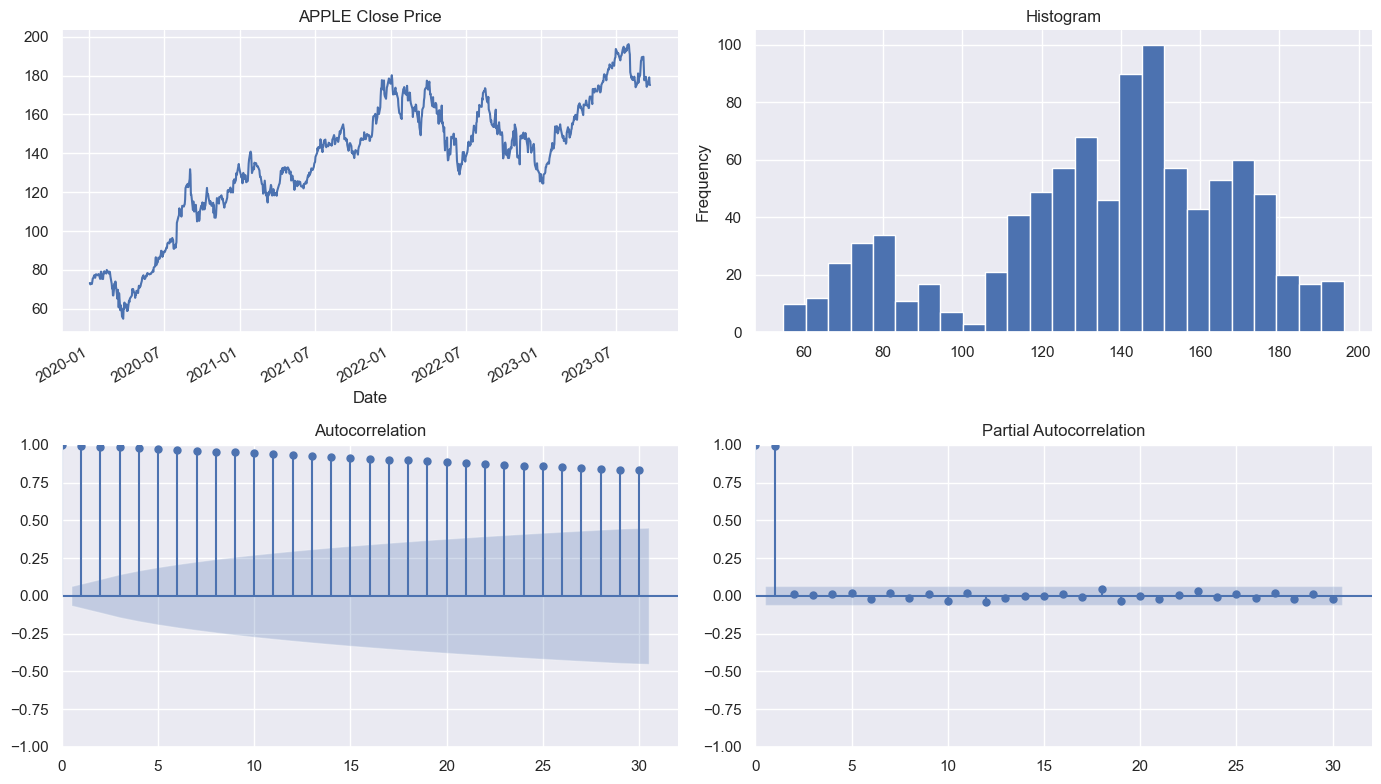

In [30]:
tsplot(AAPLStock['Close'], title = 'APPLE Close Price')
plt.show()

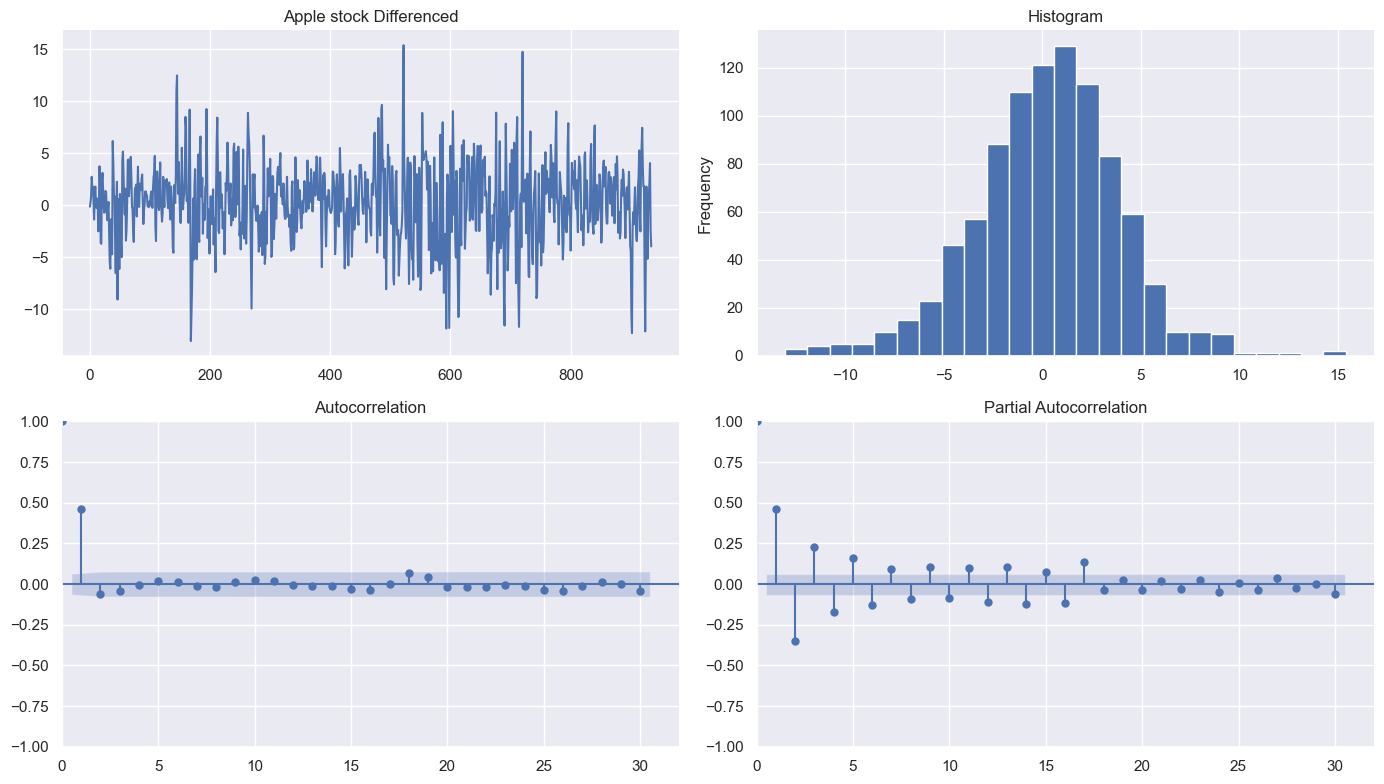

In [31]:
AAPLStockDiff = difference(AAPLStock['Close'], 2)
tsplot(AAPLStockDiff, title='Apple stock Differenced') 
plt.show()

In [32]:
adf(AAPLStockDiff)

ADF Test Results: 
Test Statistic: -6.7742
p-value: 0.0000000026
Critical Values: 
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [33]:
kpss(AAPLStockDiff)

KPSS Test Results: 
Test Statistic: 0.0821
p-value: 0.1000000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [34]:
#Once stock is differenced now we will begin to fit the ARIMA model for Apple Stock prices 
AIC_BIC_HQIC(AAPLStockDiff)

AIC (0, 1)
BIC (0, 1)
HQIC (0, 1)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  935
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -2579.669
Date:                Fri, 21 Mar 2025   AIC                           5165.339
Time:                        12:20:34   BIC                           5179.854
Sample:                             0   HQIC                          5170.874
                                - 935                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0096      0.034     -0.284      0.776      -0.076       0.057
ma.L1         -1.0000      7.772     -0.129      0.898     -16.232      14.232
sigma2        14.6518    113.924      0.129      0.8

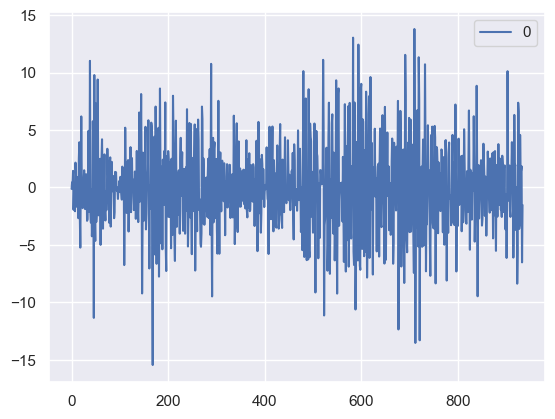

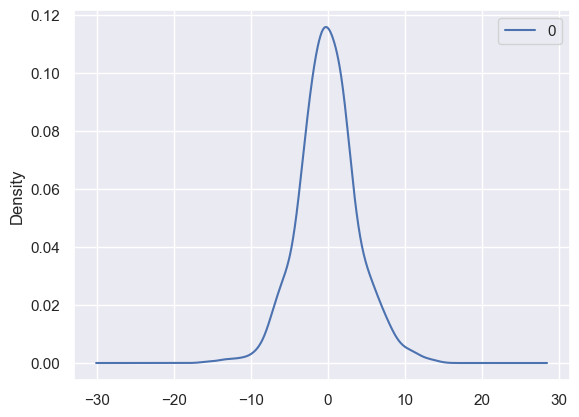

                0
count  935.000000
mean    -0.008562
std      3.834085
min    -15.463409
25%     -2.265659
50%     -0.118779
75%      2.163940
max     13.787113


In [35]:
# fit model
model = ARIMA(AAPLStockDiff, order=(1,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## MICROSOFT STOCK ANALYSIS W/ FINANCIAL DATA


In [37]:
# Import our data 
df1MSFT = pd.read_csv('FinancialDatasets/MSFTStock&SentimentData.csv')
df1MSFT = df1MSFT[['Date','Close', 'sentiment_score']] # Just take the Adjusted closing value and Sentiment columns
df1MSFT.head()

,Date,Close,sentiment_score
0,2021-09-30,281.920013,0.246480
1,2021-10-01,289.100006,0.359337
2,2021-10-04,283.109985,0.258650
3,2021-10-05,288.760010,0.045500
4,2021-10-06,293.109985,0.194300


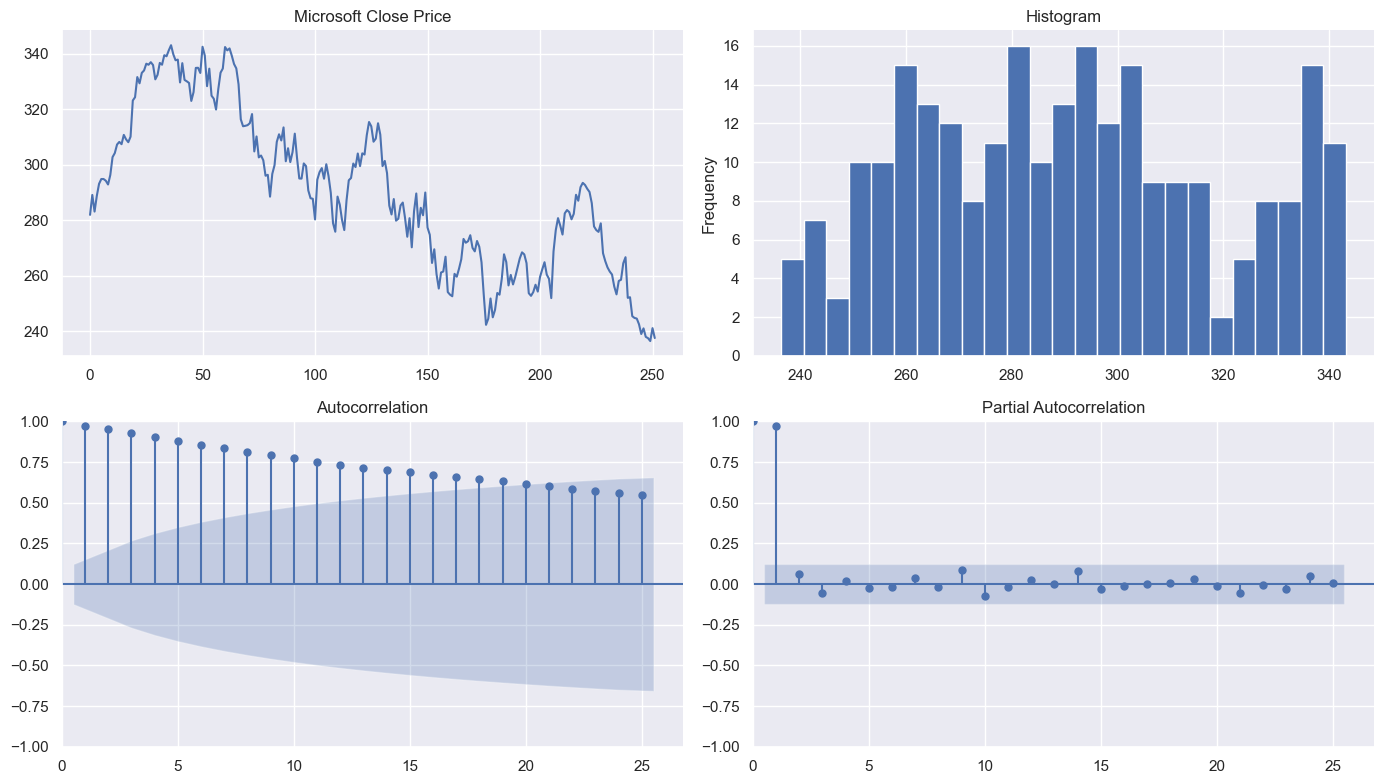

In [38]:
tsplot(df1MSFT['Close'], title='Microsoft Close Price')
plt.show()

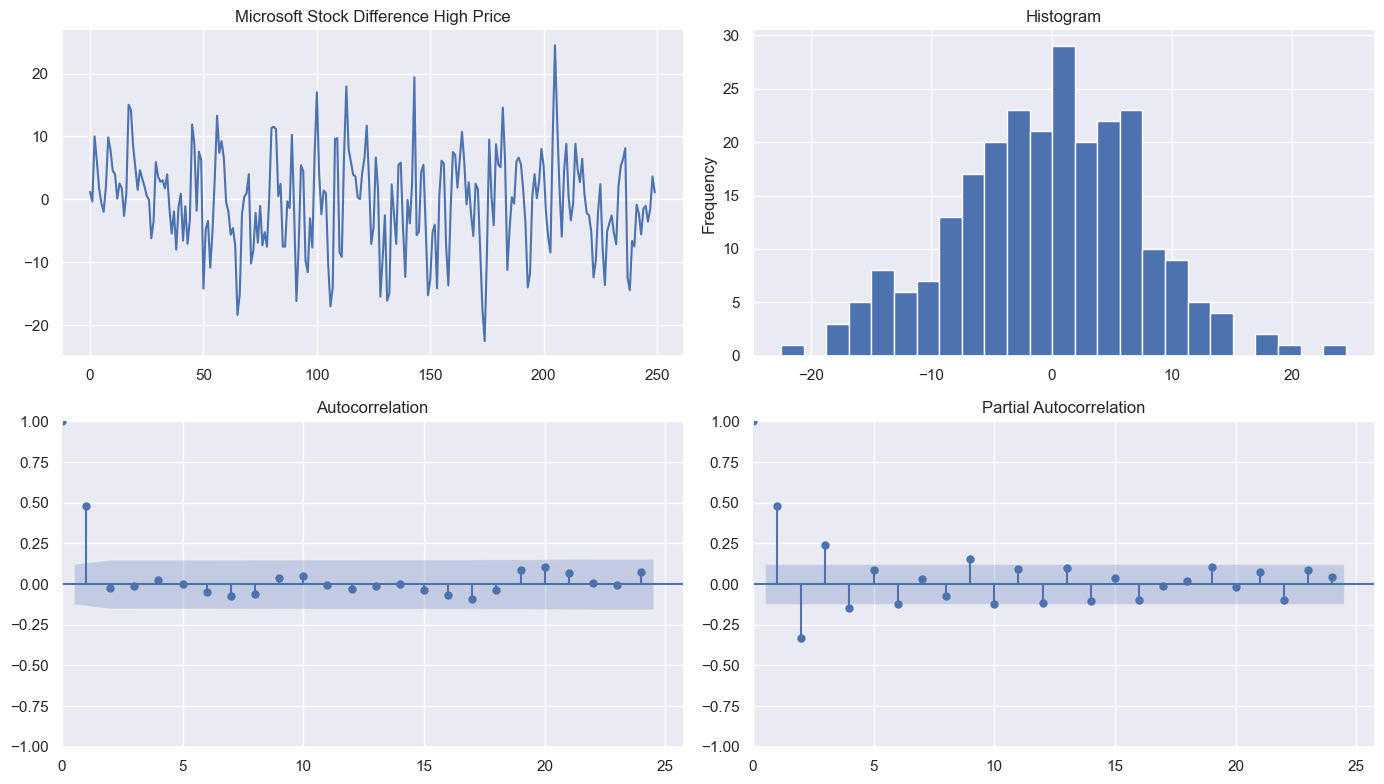

In [89]:
MSFTStockDiff = difference(df1MSFT['Close'], 2)
tsplot(MSFTStockDiff, title = 'Microsoft Stock Difference High Price')
plt.show()

## DATA ANALYSIS
**Graph 1: Top Left**

**Graph 2: Top Right**

**Auto Correlation & PACF Comparison**
By examining the auto correlation of the microsoft stock, we can see that the acf is nearing 1 if not at 1 at times. This indicates a strong positive prediction that the stock price is valued and any current stock holders should keep their stock. 

By comparing both graphs, (I will refer to Graph 1 before differencing as G1 & after G2) G1 acf shows a gradual decline and G1 PACF showing a sharp decrease indicates that our data is non-stationary. Once differencing is applied we can see that in the ACF G2 it shows a sharp decline and in the PACF graph it is a gradual decline. This means our data is now stationary, meaning, there are no trends or patterns in the data.

Both have been applied to Apple stock (AAPL) and Microsoft (MSFT). 

Once results have been shown to be accurate and fully functional the last stock Amazon will be used to fully complete analysation of all 3 stocks 

In [41]:
print("MICROSOFT STOCK DATASET STATS\n")
adf(MSFTStockDiff)

MICROSOFT STOCK DATASET STATS

ADF Test Results: 
Test Statistic: -4.2843
p-value: 0.0004729240
Critical Values: 
	1%: -3.459
	5%: -2.874
	10%: -2.573


## P-VALUE STAT
Looking at the satatistics above we notice that the P-Value is 0. This mean that the null hypothises is true. P(E) = 0 if and only if event E is impossible. 

Due to the Test statistics being less than all critical values we can reject the null hypothises and conclude the difference series is stationary. This will apply to Apple and Amazon stock 

In [43]:
AIC_BIC_HQIC(MSFTStockDiff)

AIC (0, 1)
BIC (0, 1)
HQIC (0, 1)


**Fitting the ARIMA Model**
We will now begin to fit our model using the ARIMA (1, 2, 1)

- 1 lag steps for auto-regression (AR)
- 2nd order differencing (I)
- 1 moving average term (MA)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -864.004
Date:                Fri, 21 Mar 2025   AIC                           1734.009
Time:                        12:20:41   BIC                           1744.549
Sample:                             0   HQIC                          1738.252
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0113      0.074     -0.153      0.878      -0.156       0.133
ma.L1         -0.9999      5.933     -0.169      0.866     -12.629      10.629
sigma2        60.8015    360.777      0.169      0.8

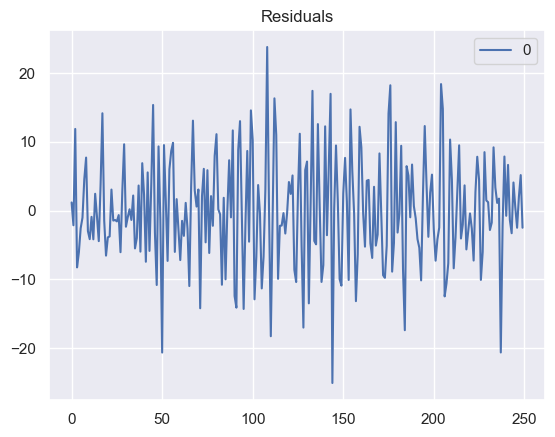

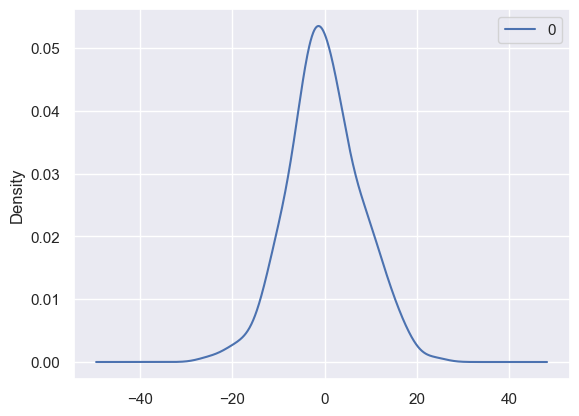

                0
count  250.000000
mean    -0.014117
std      7.853983
min    -25.046520
25%     -4.740940
50%     -0.594914
75%      4.540935
max     23.777744


In [45]:
# fit model
model = ARIMA(MSFTStockDiff, order=(1,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residuals')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

**How to forecast using ARIMA Model** 
Using a method called Rolling Forecast, this method will be used to forecast our future predictions. 
In a rolling forecast, the model is often retrained as new data becomes available allowing for more accurate and adaptive predictions 

**How to forecast with ARIMA** 

1. Use Predict() function on ARIMAResults object. This function will require the index of the time steps for which predictions are needed
2. Revert any differencing and return predictions in the original scale.
3. Employ the forecast() function for simplier one-step forcasting. 

Test RMSE: 7.378


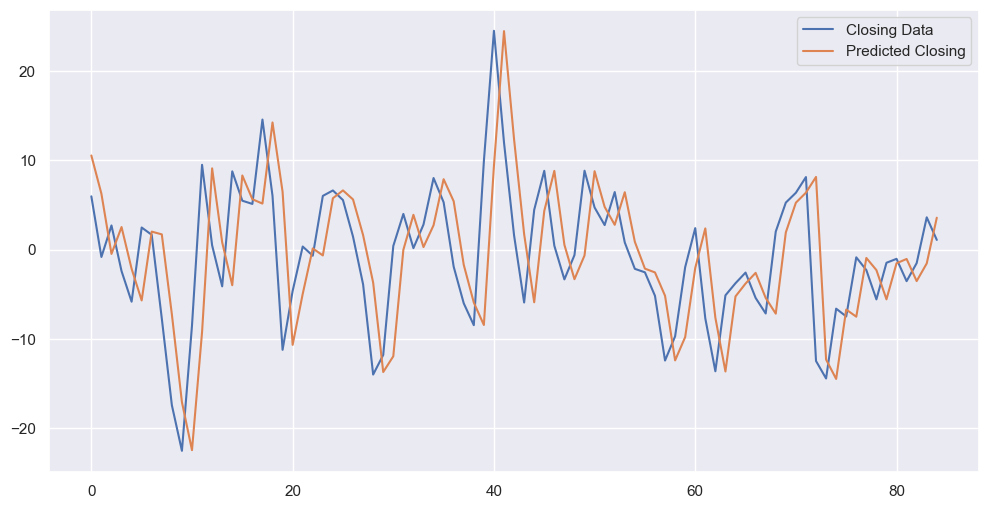

In [260]:
#split into train and test sets
X = MSFTStockDiff.values 
size = (int(len(X) * 0.66))
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
num_of_days = 0

# Walk-forward validation 
for t in range(len(test)): 
    model = ARIMA(history, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# # R2 score 
# from sklearn.metrics import r2_score 

# r2 = r2_score(test, predictions)
# print('R^2: %.3f' % r2)

#evaluate forecasts 
mse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % mse)

#plot forecasts against actual outcomes 
plt.figure(figsize=(12, 6))
plt.plot(test, label="Closing Data")
plt.plot(predictions, label="Predicted Closing")
plt.legend()
plt.show()

## MSFT STOCK WITH SENTIMENT DATA 

In [164]:
df1MSFTClose = scaler.fit_transform(df1MSFT[['Close']])
#df1MSFTClose

In [301]:
#split into train and test sets
X = df1MSFTClose
size = (int(len(X) * 0.66))
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Walk-forward validation 
for t in range(len(test)): 
    model = ARIMA(history, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))


Y = df1MSFT[['sentiment_score']].values
size = (int(len(Y) * 0.66))
trainSen, testSen = Y[0:size], Y[size:len(Y)]
historySen = [y for y in trainSen]
predictions_sen = list()

# Walk-forward validation 
for x in range(len(testSen)): 
    model = ARIMA(historySen, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sen.append(yhat)
    obs = testSen[x]
    historySen.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
mse = sqrt(mean_squared_error(predictions, test))
mse_sent = sqrt(mean_squared_error(predictions_sen, testSen))
# To get the total MSE value we can use this formula: 
# total_mse = ( (n1 * mse1) + (n2 * mse2) ) / (n1 + n2)
# Where n1 & n2 are the number of values within the dataset 

total_mse = ( (86 * mse) + (86 * mseSen) ) / (86 + 86)
print("True MSE Value: ", (total_mse * 100))

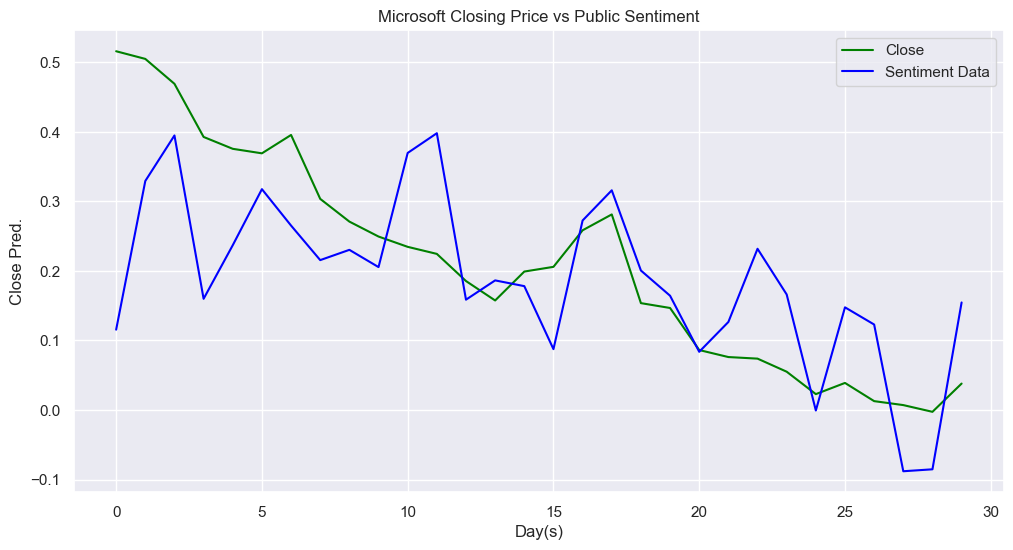

In [309]:
# Get 10, 20, 30 Day visuals of predictions 
# 10 Days
# forecasted = predictions[len(predictions)-10:]
# forecasted_sent = predictions_sen[len(predictions_sen)-10:]
# # 20 Days
# forecasted = predictions[len(predictions)-20:]
# forecasted_sent = predictions_sen[len(predictions_sen)-20:]
# # 30 Days
forecasted = predictions[len(predictions)-30:]
forecasted_sent = predictions_sen[len(predictions_sen)-30:]

# plot forecasts against actual outcomes 
plt.figure(figsize=(12, 6))
plt.title('Microsoft Closing Price vs Public Sentiment')
plt.xlabel('Day')
plt.ylabel('Close Pred.')
plt.plot(forecasted, label='Close', color='green')
plt.plot(forecasted_sent, label='Sentiment Data', color='blue')
plt.xlabel('Day(s)')
plt.legend(['Close', 'Sentiment Data'])
plt.show()

## APPLE Stock & Sentiment - DF2

In [115]:
df2 = pd.read_csv('FinancialDatasets/AAPLStock&Sentiment.csv')
df2 = df2[['Date', 'Close', 'sentiment_scores']]
df2

,Date,Close,sentiment_scores
0,2021-09-30,191.486836,0.098900
1,2021-10-01,193.286088,0.291891
2,2021-10-04,189.333359,0.047410
3,2021-10-05,192.738946,0.139060
4,2021-10-06,194.692045,0.190330
...,...,...,...
247,2022-09-23,144.871999,0.018900
248,2022-09-26,144.398001,0.289800
249,2022-09-27,144.797200,0.256164
250,2022-09-28,148.652000,-0.042374


In [172]:
scaler = MinMaxScaler(feature_range=(0, 1))
df2AAPLClose = scaler.fit_transform(df2[['Close']])

In [287]:
#split into train and test sets
X = df2AAPLClose
size = (int(len(X) * 0.66))
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Walk-forward validation 
for t in range(len(test)): 
    model = ARIMA(history, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Y = df2[['sentiment_scores']].values
size = (int(len(Y) * 0.66))
trainSen, testSen = Y[0:size], Y[size:len(Y)]
historySen = [y for y in trainSen]
predictions_sen = list()

# Walk-forward validation 
for x in range(len(testSen)): 
    model = ARIMA(historySen, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sen.append(yhat)
    obs = testSen[x]
    historySen.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [242]:
# evaluate forecasts 
mse = sqrt(mean_squared_error(predictions, test))
mse_sent = sqrt(mean_squared_error(predictions_sen, testSen))
# To get the total MSE value we can use this formula: 
# total_mse = ( (n1 * mse1) + (n2 * mse2) ) / (n1 + n2)
# Where n1 & n2 are the number of values within the dataset 

total_mse = ( (86 * mse) + (86 * mseSen) ) / (86 + 86)
print("True MSE Value: ", (total_mse * 100))

True MSE Value:  2.2456231020496977


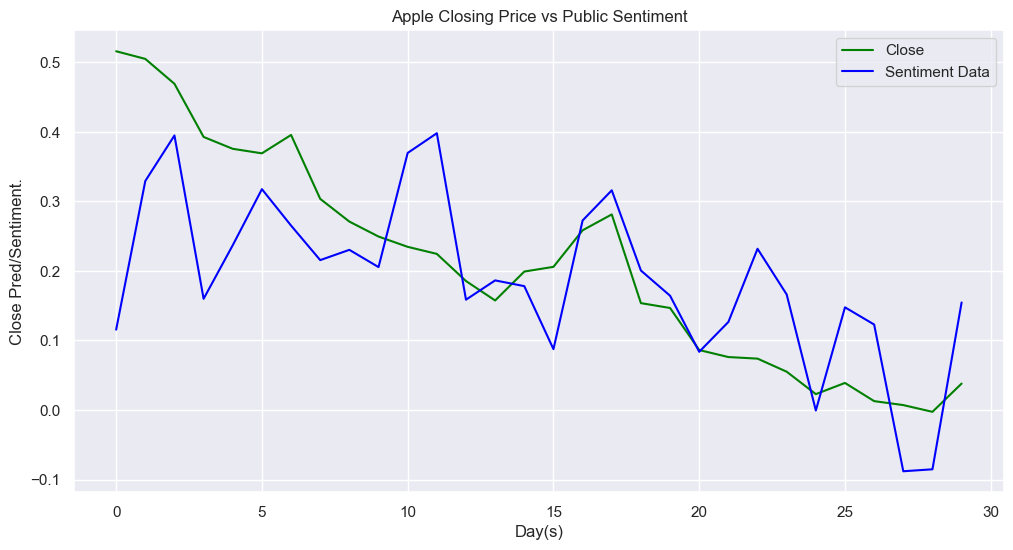

In [299]:
# Get 10, 20, 30 Day visuals of predictions 
# 10 Days
# forecasted = predictions[len(predictions)-10:]
# forecasted_sent = predictions_sen[len(predictions_sen)-10:]
# # 20 Days
# forecasted = predictions[len(predictions)-20:]
# forecasted_sent = predictions_sen[len(predictions_sen)-20:]
# # 30 Days
forecasted = predictions[len(predictions)-30:]
forecasted_sent = predictions_sen[len(predictions_sen)-30:]

# plot forecasts against actual outcomes 
plt.figure(figsize=(12, 6))
plt.title('Apple Closing Price vs Public Sentiment')
plt.ylabel('Close Pred/Sentiment.')
plt.plot(forecasted, label='Close', color='green')
plt.plot(forecasted_sent, label='Sentiment Data', color='blue')
plt.xlabel('Day(s)')
plt.legend(['Close', 'Sentiment Data'])
plt.show()

## AMAZON Stock & Sentiment Data - DF3

In [119]:
df3 = read_csv('FinancialDatasets/AMZNStock&Sentiment.csv')
df3 = df3[['Date', 'Close', 'sentiment_score']]
df3.head()

,Date,Close,sentiment_score
0,2021-09-30,164.251999,0.246480
1,2021-10-01,164.162994,0.359337
2,2021-10-04,159.488998,0.258650
3,2021-10-05,161.050003,0.045500
4,2021-10-06,163.100494,0.194300


In [252]:
# Normalise adj close 
scaler = MinMaxScaler(feature_range=(0, 1))
df3AMZNClose = scaler.fit_transform(df3[['Close']])
#df3AMZNClose

In [275]:
#split into train and test sets
X = df3AMZNClose
size = (int(len(X) * 0.66))
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# Walk-forward validation 
for t in range(len(test)): 
    model = ARIMA(history, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Y = df3[['sentiment_score']].values
size = (int(len(Y) * 0.66))
trainSen, testSen = Y[0:size], Y[size:len(Y)]
historySen = [y for y in trainSen]
predictions_sen = list()

# Walk-forward validation 
for x in range(len(testSen)): 
    model = ARIMA(historySen, order=(1, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_sen.append(yhat)
    obs = testSen[x]
    historySen.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [255]:
# mse = sqrt(mean_squared_error(predictions, test))
# mse_sent = sqrt(mean_squared_error(predictions_sen, testSen))

# # To get the total MSE value we can use this formula: 
# # total_mse = ( (n1 * mse1) + (n2 * mse2) ) / (n1 + n2)
# # Where n1 & n2 are the number of values within the dataset 

# total_mse = ( (86 * mse) + (86 * mseSen) ) / (86 + 86)
# print("True MSE Value: ", (total_mse * 100))

True MSE Value:  2.2456231020496977


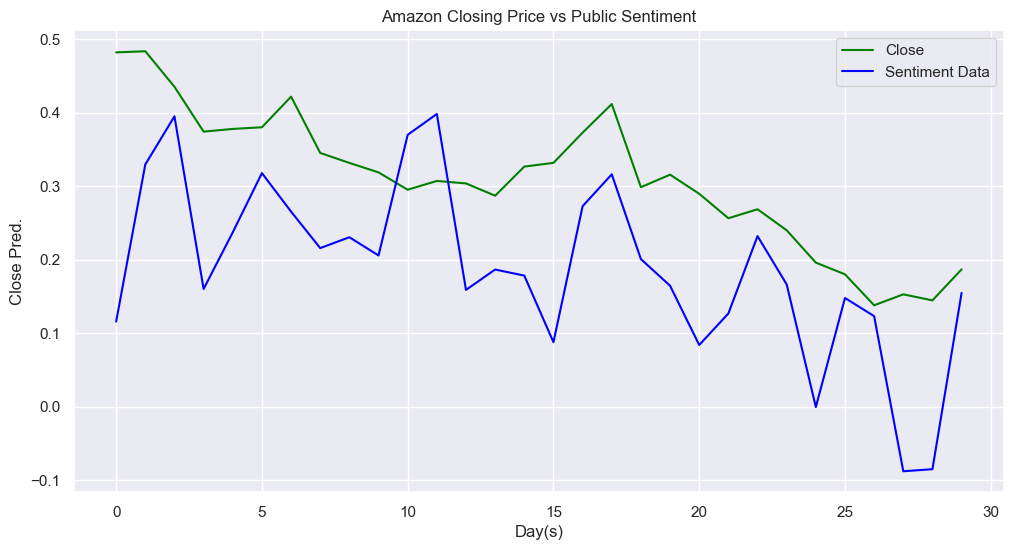

In [285]:
# Get 10, 20, 30 Day visuals of predictions 
# 10 Days
# forecasted = predictions[len(predictions)-10:]
# forecasted_sent = predictions_sen[len(predictions_sen)-10:]
# # 20 Days
# forecasted = predictions[len(predictions)-20:]
# forecasted_sent = predictions_sen[len(predictions_sen)-20:]
# # 30 Days
forecasted = predictions[len(predictions)-30:]
forecasted_sent = predictions_sen[len(predictions_sen)-30:]

# plot forecasts against Predicted 
plt.figure(figsize=(12, 6))
plt.title('Amazon Closing Price vs Public Sentiment')
plt.ylabel('Close Pred.')
plt.plot(forecasted, label='Close', color='green')
plt.plot(forecasted_sent, label='Sentiment Data', color='blue')
plt.xlabel('Day(s)')
plt.legend(['Close', 'Sentiment Data'])
plt.show()